In [1]:
import cv2
import os
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from detector import get_info,zoom_people,detect_hands,blur_person

G:\Mi unidad\Universidad\Investigacion\SOS_detect_Special_Issue_2022\code\mp_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\virgi/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-5-16 Python-3.7.8 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [102]:
def get_bbox(image, marks):
    height, width, _ = image.shape
    landmarks = []

    # Iterate over the detected landmarks of the hand.
    for landmark in marks.landmark:

        # Append the landmark into the list.
        landmarks.append((int(landmark.x * width), int(landmark.y * height),(landmark.z * width)))

    padd_amount = 10

    # Get all the x-coordinate values from the found landmarks of the hand.
    x_coordinates = np.array(landmarks)[:,0]

    # Get all the y-coordinate values from the found landmarks of the hand.
    y_coordinates = np.array(landmarks)[:,1]

    # Get the bounding box coordinates for the hand with the specified padding.
    x1  = int(np.min(x_coordinates) - padd_amount)
    y1  = int(np.min(y_coordinates) - padd_amount)
    x2  = int(np.max(x_coordinates) + padd_amount)
    y2  = int(np.max(y_coordinates) + padd_amount)
    
    return x1,y1, x2,y2

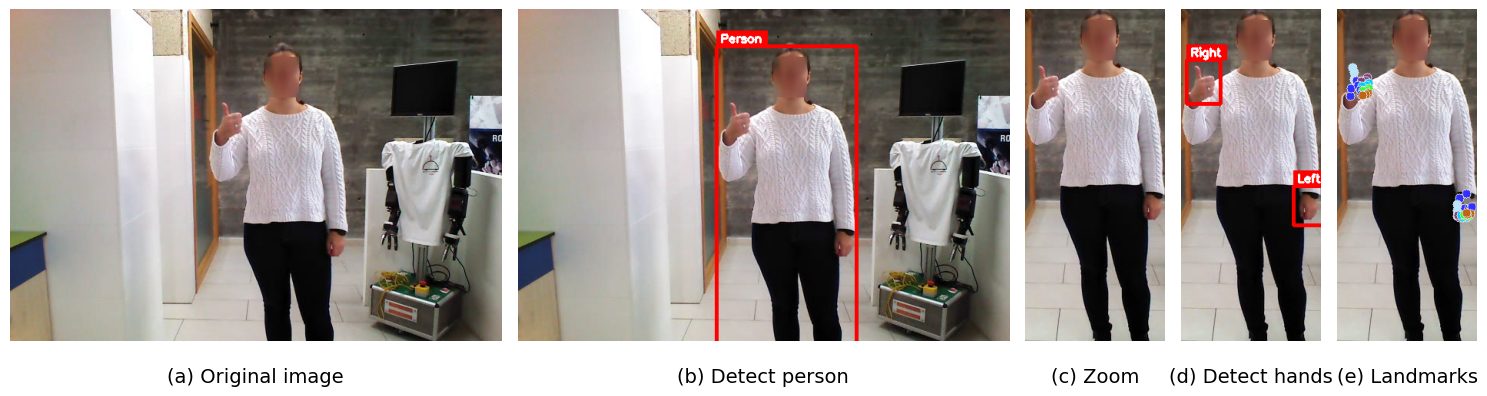

In [190]:
image = '../images/user14/user14_1_rn1_20.png'

img = cv2.imread(image)
#img = cv2.flip(img, 1) # Mirror image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_blur = blur_person(img)

zoom_images, zoom_positions = zoom_people(img, positions=True)
img_person = img_blur.copy()
bbox = zoom_positions[0]
cv2.rectangle(img_person,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,0,0),3)
label = 'Person'
(w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
cv2.rectangle(img_person, (bbox[0], bbox[1] - 20), (bbox[0] + w +10, bbox[1]), (255,0,0), -1)
cv2.putText(img_person, label, (bbox[0]+5, bbox[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

zoom_img = img_blur[bbox[1]:bbox[3],bbox[0]:bbox[2],:]

hands_img = zoom_img.copy()
marks_img = zoom_img.copy()

hands = detect_hands(hands_img, process_landmark=False)
for label, hand in zip(['Left', 'Right'], ['Right', 'Left']): #Because there's no flip
    bbox_hl = get_bbox(zoom_img, hands[hand])
    cv2.rectangle(hands_img, (bbox_hl[0],bbox_hl[1]),(bbox_hl[2],bbox_hl[3]),(255,0,0),3)
    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
    cv2.rectangle(hands_img, (bbox_hl[0], bbox_hl[1] - 20), (bbox_hl[0] + w +10, bbox_hl[1]), (255,0,0), -1)
    cv2.putText(hands_img, label, (bbox_hl[0]+5, bbox_hl[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

    mp_drawing.draw_landmarks(marks_img, hands[hand], mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style())

w_big = img_blur.shape[1]
w_small = zoom_img.shape[1]
    
fontsize = 14
fig, ax = plt.subplots(1,5, figsize=(15, 5),gridspec_kw={'width_ratios': [w_big,w_big,w_small,w_small,w_small]},sharey=True)
for i in range(5):
    ax[i].axis('off')
    
ax[0].imshow(img_blur)
ax[0].set_title('(a) Original image', y=-0.15, fontsize = fontsize)

ax[1].imshow(img_person)
ax[1].set_title('(b) Detect person', y=-0.15, fontsize = fontsize)

ax[2].imshow(zoom_img)
ax[2].set_title('(c) Zoom', y=-0.15, fontsize = fontsize)

ax[3].imshow(hands_img)
ax[3].set_title('(d) Detect hands', y=-0.15, fontsize = fontsize)

ax[4].imshow(marks_img)
ax[4].set_title('(e) Landmarks', y=-0.15, fontsize = fontsize)

    
plt.tight_layout()
plt.savefig('results/img_process_hands.pdf', bbox_inches='tight', dpi=300)

plt.show()